# SCRAPING CHALLENGE

## 1 - VALUE PROPOSTITIONS

Web scraping do Diário Oficial do Município da cidade de Salvador (BA).<br>
Formato de entrega: .json<br><br>
Destaque às ferramentas: bibliotecas do Python e soluções de leitura de texto (OCR/Tesseract, etc.)<br><br>
Esquema:
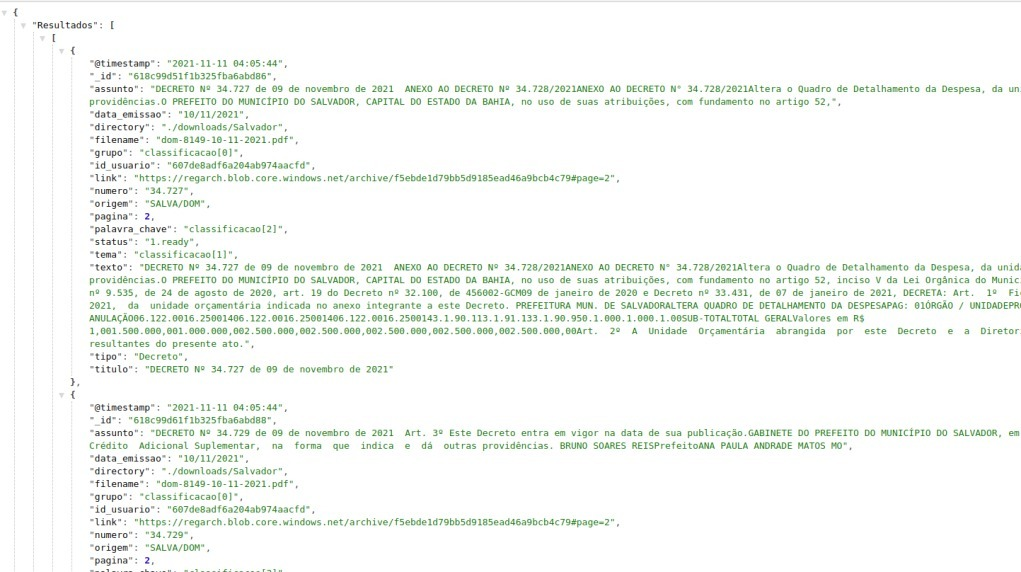

## 2 - Data sources

Os arquivos dos diários oficiais estão em formato PDF dentro do site http://www.dom.salvador.ba.gov.br/
<br>
Desde a primeira publicação até o dia 27-Nov-2021, foram emitidas 8162 edições.<br>
A primeira edição foi publicada em `03 de setembro de 1986` e uma das primeiras etapas do código é obter a associação entre o número do DOM e a data de publicação. Com essa etapa, consegue-se descobrir a data de início das publicações.<br>
Normalmente, uma edição é divulgada em cada dia de semana, com exceção de feriados ou pontes.<br>
Eventuais edições são lançadas em sábados, domingos ou feriados.<br>
Em alguns casos, mais de uma edição do DOM é lançada no mesmo dia, sendo do tipo "EXTRA".<br><br>
Cada PDF está localizado em um endereço que segue um padrão do tipo:<br>
http://www.dom.salvador.ba.gov.br/images/stories/pdf/ `ANO`/`NOME_DO_MES`/`nome_arquivo.pdf`<br>
Sendo:<br>
`ANO`: 4 dígitos que representam o ano.<br>
`NOME_DO_MES`: nome, por extenso, do mês de uma determinada edição, grafado integralmente em letras minúsculas e sem acentos. Especificamente o mês de março-2019 tem sua pasta grafada com a palavra `Marco` contendo a primeira letra maiúscula.<br>
`nome_arquivo.pdf`: nome do arquivo PDF, seguindo um padrão.<br>
Padrão para o nome dos arquivos:<br>
`dom-NÚMERO_DOM-DIA-MES-ANO.pdf` ou `DOM-NÚMERO_DOM-DIA-MES-ANO.pdf`<br><br>
Em que:
`dom` ou `DOM`: a sigla "DOM", escrita com letras maiúsculas (formato mais comum entre 1986 e 2004, assim como nos anos de 2009 a 2012) ou minúsculas (formato mais comum entre 2005 a 2009, bem como a partir de 2013).<br>
`NÚMERO_DOM`: número da edição do DOM, composta de 4 dígitos. Primeira edição: 0001.<br>
`DIA`: dois dígitos representando o dia, variando de 1 até 31. Dias de 1 a 9 são representados com um 0 antes. Ex: 01 e não 1.<br>
`MES`: dois dígitos representando o mês, variando de 1 até 12. Meses de 1 a 9 são representados com um 0 antes.<br>
`ANO`: quatro dígitos representando o ano.<br>

Exemplo: o endereço do diário de número `8104`, publicado no dia `03 de setembro de 2021` será:<br>
http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/setembro/dom-8104-03-09-2021.pdf

Eventualmente, há erros e exceções nesse padrão, mas essa quantidade corresponde a apenas 0,37% dos casos.

## 3 - Collecting Data

Em primeiro lugar, será gerada uma tabela contendo a relação entre o número de cada DOM, a data da sua emissão e o URL em que a edição se encontra, conforme o modelo abaixo:<br>

|   No_DOM | Data       | URL                                                                                         |
|---------:|:-----------|:--------------------------------------------------------------------------------------------|
|     8164 | 2021-12-01 | http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/dezembro/dom-8164-01-12-2021.pdf  |
|     8163 | 2021-11-30 | http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/novembro/dom-8163-30-11-2021.pdf  |
|     8162 | 2021-11-27 | http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/novembro/dom-8162-27-11-2021.pdf  |
|     8161 | 2021-11-26 | http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/novembro/dom-8161-26-11-2021.pdf  |
|     8160 | 2021-11-25 | http://www.dom.salvador.ba.gov.br/images/stories/pdf/2021/novembro/dom-8160-25-11-2021.pdf  |

Gerada esta lista, os dados que irão ao arquivo .json serão captados entrando-se em cada um dos URLs que foram encontrados e armazenados na tabela.

Para se gerar a lista que correlaciona número do DOM com data de publicação e URL:
1. Na página inicial do DOM estão disponíveis as 5 edições mais recentes. Começa-se criando a lista com essas 5 edições mais recentes. Faz-se um scraping nesta primeira página.
2. Todos os diários estão contidos em um diretório online relacionado ao seu mês e ano. Na primeira rodagem deste programa, gerou-se a lista de todos os diários, entre a edição 0001 e a edição 8162 a partir do scraping do conteúdo do diretório de cada mês e ano. Para se fazer o scraping da pasta de cada mês, usou-se: `from urllib.request import urlopen` para acessar cada diretório.
3. Procura-se todos os números DOM que estejam ainda faltando na lista, a partir do seu número e testando-se suas possíveis datas de emissão.
4. Salva-se esta lista em um .csv que será usado nas execuções seguintes. Em todas as demais execuções do programa, ao invés de fazer o scraping novamente de toda a base de dados dos diários, apenas se carregará esse .csv, chamado `lista_DOM_datas.csv` e nele serão incrementados os dados dos diários adicionados entre a última execução e a data atual.

### 3.1 Importação das bibliotecas

Bibliotecas de uso geral

In [1]:
# Será usada para se armazenar a relação DOM x Data x URL e diversos outros armazenamentos em tabela
import pandas as pd

# Manipulações numéricas
import numpy as np

# Será usada para manipular as datas
import datetime as dt

# Calcular tempo de execução de partes do código
import time

# Será usada para se formar os nomes por extenso dos meses
import locale
locale.setlocale(locale.LC_ALL, "pt_BR.UTF-8")

'pt_BR.UTF-8'

Bibliotecas que serão usadas para o acesso aos URLs do Diário

In [2]:
# Será usada para tentar abrir cada URL
import urllib.request
from urllib.request import urlopen
import requests

# Tratamentos de exceções
from urllib.error import HTTPError # Definição dos erros HTTPError, para evidenciar erros 404, quando as páginas não existem
from urllib.error import URLError # Definição dos erros URLError, quando as páginas existem, mas há outros erros de acesso

# Biblioteca que será usada para procurar as informações dentro dos códigos-fonte das páginas
from bs4 import BeautifulSoup 

# Tratamento de expressões regulares
import re

In [3]:
# Para as leituras em si dos PDFs
from PyPDF2 import PdfFileReader

# Tratamentos de entrada/saída
import io

### 3.2 Funções auxiliares e variáveis globais

In [4]:
pag_inicial = 'http://www.dom.salvador.ba.gov.br/'

In [5]:
def preenche_iniciais():
    global pag_inicial

    formato_url_dom = '/images/stories/pdf/[0-9]{4}/[a-z]{4,9}/[a-z]{3}\-[0-9]{4}\-[0-9]{2}\-[0-9]{2}\-[0-9]{4}'
    
    dict_DOM_data = {}
    dict_DOM_url = {}
    
    try:
        html = urlopen(pag_inicial)
        bs = BeautifulSoup(html, 'html.parser')
    
    except HTTPError as e:
        print('ERRO HTTPError!')
    
    except URLError as e:
        print('ERRO URLError!')
        
    else:
        todos_URL = list(set(re.findall(formato_url_dom, str(bs))))
        
        for url in todos_URL:
            dom = url[re.search('dom', url).start():][4:8]
            data = url[re.search('dom', url).start():][-10:]
            data = dt.datetime.strptime(data, '%d-%m-%Y').date()
            dict_DOM_data[dom] = data
            dict_DOM_url[dom] = pag_inicial[:-1] + url + '.pdf'
        
    df_inicial = pd.DataFrame(data={'No_DOM':list(dict_DOM_data.keys())})
    
    df_inicial['Data'] = df_inicial.apply(lambda x: dict_DOM_data[x['No_DOM']], axis=1)
    df_inicial['URL'] = df_inicial.apply(lambda x: dict_DOM_url[x['No_DOM']], axis=1)
    
    df_inicial = df_inicial.drop_duplicates()
    
    df_inicial = df_inicial.sort_values(by='No_DOM', ascending=False).reset_index(drop=True)
    
    return df_inicial

In [6]:
def monta_URL_meses(ano_inicio, ano_final, flag_mes_upper=0):
    dict_dir_meses = {}
    
    global pag_inicial
    
    url_comum = pag_inicial + 'images/stories/pdf/'
    
    for ano in range(ano_inicio, ano_final+1):
        for mes in range(1,13):
            nome_per = str(ano).zfill(2) + '-' + str(mes).zfill(2)
            if(dt.datetime(ano, mes, 1).strftime('%B') == 'março'):
                nome_mes = 'marco'
            else:
                nome_mes = dt.datetime(ano, mes, 1).strftime('%B')
            
            if(flag_mes_upper == 0):
                dict_dir_meses[nome_per] = url_comum + str(ano).zfill(4) + '/' + nome_mes
            
            elif(flag_mes_upper == 1):
                dict_dir_meses[nome_per] = url_comum + str(ano).zfill(4) + '/' + nome_mes.title()
    
    return dict_dir_meses

In [7]:
def monta_URL_por_data(no_dom, data, prefixo='http', flag_upper_dom=0, flag_mes_upper=0, flag_mes_dif=0):
    global pag_inicial
    
    url_comum = prefixo + pag_inicial[4:] + 'images/stories/pdf/'
    
    if(flag_mes_dif == 0):
        nome_mes = data.strftime('%B')
        ano_data = str(data.year).zfill(4)
    else:
        if(flag_mes_dif < 0):
            data_ref = dt.date(data.year, data.month, 1) - dt.timedelta(1)
        elif(flag_mes_dif > 0):
            data_ref = dt.date(data.year, data.month, 1) + dt.timedelta(31)
        
        nome_mes = data_ref.strftime('%B')
        ano_data = str(data_ref.year).zfill(4)
    
    nome_dom = 'dom'
    
    
    if(nome_mes == 'março'):
        nome_mes = 'marco'
    
    if(flag_mes_upper == 1):
        nome_mes = nome_mes.title()
        
    if(flag_upper_dom == 1):
        nome_dom = nome_dom.upper()
    
    data_str = data.strftime('%d-%m-%Y')
    
    end_URL = url_comum + ano_data + '/' + nome_mes + '/' + nome_dom + '-' + no_dom + '-' + data_str + '.pdf'
    
    end_URL = end_URL.replace('arço', 'arco')
    
    return end_URL

In [8]:
def verifica_url(download_url):
    a = ''
    try:
        response = urllib.request.urlopen(download_url)    
        #response = urlopen(download_url)    
    
    except HTTPError as e:
        a = 'ERRO HTTPError!'
        
    except URLError as e:
        a = 'ERRO URLError!'
    
    else:
        a = 'SUCESSO'
        
    return a

In [9]:
def busca_mes_a_mes_inicial(df_primeiro):
    dict_URL_meses = monta_URL_meses(1986, 2021)
    
    dict_DOM_url = {}
    dict_DOM_datas = {}
    
    for url_mes in dict_URL_meses:
        try:
            html = urlopen(dict_URL_meses[url_mes])
            bs = BeautifulSoup(html, 'html.parser')
            
        except HTTPError as e:
            print(f'Houve erro do tipo HTTPError ao tentar acessar o URL para o período {url_mes}')
            
        except URLError as e:
            print(f'Houve erro do tipo URLError ao tentar acessar o URL para o período {url_mes}')
            
        else:
            pdf_list = bs.findAll("a")
            for name in pdf_list:
                #print(f'PASSOU POR AQUI - PERÍODO {url_mes}')
                #print(name.get_text())
                if '.pdf' in name.get_text():
                    nome_arquivo = name.get_text()
                    no_dom = nome_arquivo[:8][-4:]
                    data_dom = dt.datetime.strptime(nome_arquivo[-14:][:10], '%d-%m-%Y').date()
                    url_dom = dict_URL_meses[url_mes] + '/' + name.get_text()
                    dict_DOM_url[no_dom] = url_dom
                    dict_DOM_datas[no_dom] = data_dom
                    #print(f'DOM {no_dom} foi publicado na data {data_dom} - URL: {url_dom}')
    
    
    df_mes_a_mes_inicial = pd.DataFrame(data = {'No_DOM':list(dict_DOM_url.keys())})
    
    df_mes_a_mes_inicial['Data'] = df_mes_a_mes_inicial.apply(lambda x: dict_DOM_datas[x['No_DOM']], axis=1)
    df_mes_a_mes_inicial['URL'] = df_mes_a_mes_inicial.apply(lambda x: dict_DOM_url[x['No_DOM']], axis=1)
    
    df_mes_a_mes_inicial = df_mes_a_mes_inicial.append(df_primeiro).sort_values(by='No_DOM', ascending=False).reset_index(drop=True)
    
    return df_mes_a_mes_inicial

In [10]:
# Função que calcula a menor e a maior data possível para um DOM não encontrado
def calcula_menor_maior_data(df, no_dom):
    df_calc = df.copy()

    no_dom_int = int(no_dom)
    
    df_calc = df_calc.rename(columns={'No_DOM':'No_DOM_INT'})
    df_calc['No_DOM_INT'] = df_calc['No_DOM_INT'].astype(int)
    
    data_menor = df_calc.loc[df_calc['No_DOM_INT'] < no_dom_int].sort_values(by='No_DOM_INT', ascending=False).head(1).reset_index(drop=True).iloc[0,1]
    data_maior = df_calc.loc[df_calc['No_DOM_INT'] > no_dom_int].sort_values(by='No_DOM_INT', ascending=True).head(1).reset_index(drop=True).iloc[0,1]
    
    lista_datas = [data_menor, data_maior]
    return lista_datas

In [11]:
# Procurará cada DOM diretamente por seu arquivo PDF, supondo que seu URL segue um padrão igual aos demais
def busca_DOM_faltantes_1(df_completar_1):
    df_com_faltantes_1 = df_completar_1.copy()
    
    dict_DOM_preencher_datas = {}
    dict_DOM_preencher_URL = {}
    
    lista_DOM_possiveis = []
    lista_preenchidos_1 = list(df_com_faltantes_1.iloc[:,0])
    lista_DOM_faltantes_1 = [] # Lista de cada DOM faltante a encontrar
    
    dict_DOM_datas_preenchidos_1 = {list(df_com_faltantes_1.iloc[:,0])[i]: list(df_com_faltantes_1.iloc[:,1])[i] for i in range(len(df_com_faltantes_1))}
    
    dict_DOM_menor_data_poss = {}
    dict_DOM_maior_data_poss = {}
    
    for i in range(1, int(max(df_com_faltantes_1.iloc[:,0])) + 1):
        n_dom_testar = str(i).zfill(4)
        lista_DOM_possiveis.append(n_dom_testar)
        if(n_dom_testar not in lista_preenchidos_1):
            lista_DOM_faltantes_1.append(n_dom_testar)
    
    lista_preenchidos_1.sort()
    lista_preenchidos_1_int = list(map(int, lista_preenchidos_1))
    lista_DOM_faltantes_1.sort()
    lista_DOM_faltantes_1_int = list(map(int, lista_DOM_faltantes_1))
    
    for i in lista_DOM_faltantes_1_int:
        dict_DOM_menor_data_poss[str(i).zfill(4)] = calcula_menor_maior_data(df = df_com_faltantes_1, no_dom = str(i).zfill(4))[0]
        dict_DOM_maior_data_poss[str(i).zfill(4)] = calcula_menor_maior_data(df = df_com_faltantes_1, no_dom = str(i).zfill(4))[1]
#         l_max = []
#         l_min = []
#         for j in lista_preenchidos_1_int:
#             if(j<i):
#                 l_max.append(j)
#             elif(j>i):
#                 l_min.append(j)
#         #print('\n')
#         #print(f'O maior abaixo de {i} vale {max(l_max)}')
#         #print(f'O menor acima de {i} vale {min(l_min)}')
#         dict_DOM_menor_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_1[str(max(l_max)).zfill(4)]
#         dict_DOM_maior_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_1[str(min(l_min)).zfill(4)]
#         #print(f'Menor data: {dict_DOM_menor_data_poss[i]}')
#         #print(f'Maior data: {dict_DOM_maior_data_poss[i]}')
        
    for i in dict_DOM_menor_data_poss:
        #print('\n')
        #print(f'DOM número {i} - Menor data: {dict_DOM_menor_data_poss[i]} - Maior data: {dict_DOM_maior_data_poss[i]}')
        #print(f'Diferença entre as datas: {(dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days} dias')
        
        for j in range((dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days + 1):
            a = 0 # Contabilizará se a data e o URL foram encontrados para o DOM de número i
            data_testar = dict_DOM_menor_data_poss[i] + dt.timedelta(j)
            
            teste_http_dom = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_upper=0, flag_upper_dom=0)
            teste_https_dom = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_upper=0, flag_upper_dom=0)
            
            teste_http_DOM = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_upper=0, flag_upper_dom=1)
            teste_https_DOM = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_upper=0, flag_upper_dom=1)
            
            if((verifica_url(teste_http_dom) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_dom
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_http_dom}')
                a = a + 1
            
            if((verifica_url(teste_https_dom) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_dom
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_https_dom}')
                a = a + 1
                
            
            if((verifica_url(teste_http_DOM) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_DOM
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_http_DOM}')
                a = a + 1
                
            if((verifica_url(teste_https_DOM) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_DOM
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_https_DOM}')
                a = a + 1
            
            if(a>0):
                break
    
    if(len(dict_DOM_preencher_datas) > 0):
        df_preencher = pd.DataFrame(data = {'No_DOM':list(dict_DOM_preencher_datas.keys())})

        df_preencher['Data'] = df_preencher.apply(lambda x: dict_DOM_preencher_datas[x['No_DOM']], axis=1)
        df_preencher['URL'] = df_preencher.apply(lambda x: dict_DOM_preencher_URL[x['No_DOM']], axis=1)

        df_com_faltantes_1 = df_com_faltantes_1.append(df_preencher)
        
        df_com_faltantes_1 = df_com_faltantes_1.drop_duplicates()

        df_com_faltantes_1 = df_com_faltantes_1.sort_values(by = 'No_DOM', ascending=False).reset_index(drop=True)
    
    return df_com_faltantes_1

In [12]:
# Procurará se algum mês não teve sua pasta escrita com letras maiúsculas, em vez de minúsculas
def busca_DOM_faltantes_2(df_completar_2):
    df_com_faltantes_2 = df_completar_2.copy()
    
    dict_DOM_preencher_datas = {}
    dict_DOM_preencher_URL = {}
    
    lista_DOM_possiveis = []
    lista_preenchidos_2 = list(df_com_faltantes_2.iloc[:,0])
    lista_DOM_faltantes_2 = [] # Lista de cada DOM faltante a encontrar
    
    dict_DOM_datas_preenchidos_2 = {list(df_com_faltantes_2.iloc[:,0])[i]: list(df_com_faltantes_2.iloc[:,1])[i] for i in range(len(df_com_faltantes_2))}
    
    dict_DOM_menor_data_poss = {}
    dict_DOM_maior_data_poss = {}
    
    for i in range(1, int(max(df_com_faltantes_2.iloc[:,0])) + 1):
        n_dom_testar = str(i).zfill(4)
        lista_DOM_possiveis.append(n_dom_testar)
        if(n_dom_testar not in lista_preenchidos_2):
            lista_DOM_faltantes_2.append(n_dom_testar)
    
    lista_preenchidos_2.sort()
    lista_preenchidos_2_int = list(map(int, lista_preenchidos_2))
    lista_DOM_faltantes_2.sort()
    lista_DOM_faltantes_2_int = list(map(int, lista_DOM_faltantes_2))
    
    for i in lista_DOM_faltantes_2_int:
        l_max = []
        l_min = []
        for j in lista_preenchidos_2_int:
            if(j<i):
                l_max.append(j)
            elif(j>i):
                l_min.append(j)
        #print('\n')
        #print(f'O maior abaixo de {i} vale {max(l_max)}')
        #print(f'O menor acima de {i} vale {min(l_min)}')
        dict_DOM_menor_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_2[str(max(l_max)).zfill(4)]
        dict_DOM_maior_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_2[str(min(l_min)).zfill(4)]
        #print(f'Menor data: {dict_DOM_menor_data_poss[i]}')
        #print(f'Maior data: {dict_DOM_maior_data_poss[i]}')
        
    for i in dict_DOM_menor_data_poss:
        #print('\n')
        #print(f'DOM número {i} - Menor data: {dict_DOM_menor_data_poss[i]} - Maior data: {dict_DOM_maior_data_poss[i]}')
        #print(f'Diferença entre as datas: {(dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days} dias')
        
        for j in range((dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days + 1):
            a = 0 # Contabilizará se a data e o URL foram encontrados para o DOM de número i
            data_testar = dict_DOM_menor_data_poss[i] + dt.timedelta(j)
            
            teste_http_dom = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_upper=1, flag_upper_dom=0)
            teste_https_dom = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_upper=1, flag_upper_dom=0)
            
            teste_http_DOM = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_upper=1, flag_upper_dom=1)
            teste_https_DOM = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_upper=1, flag_upper_dom=1)
            
            if((verifica_url(teste_http_dom) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_dom
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_http_dom}')
                a = a + 1
            
            if((verifica_url(teste_https_dom) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_dom
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_https_dom}')
                a = a + 1
                
            
            if((verifica_url(teste_http_DOM) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_DOM
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_http_DOM}')
                a = a + 1
                
            if((verifica_url(teste_https_DOM) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_DOM
                #print(f'O DOM de número {i} foi publicado no dia {data_testar}\nSeu URL é: {teste_https_DOM}')
                a = a + 1
            
            if(a>0):
                break
    
    if(len(dict_DOM_preencher_datas) > 0):
        df_preencher = pd.DataFrame(data = {'No_DOM':list(dict_DOM_preencher_datas.keys())})

        df_preencher['Data'] = df_preencher.apply(lambda x: dict_DOM_preencher_datas[x['No_DOM']], axis=1)
        df_preencher['URL'] = df_preencher.apply(lambda x: dict_DOM_preencher_URL[x['No_DOM']], axis=1)

        df_com_faltantes_2 = df_com_faltantes_2.append(df_preencher)

        df_com_faltantes_2 = df_com_faltantes_2.drop_duplicates()
        
        df_com_faltantes_2 = df_com_faltantes_2.sort_values(by = 'No_DOM', ascending=False).reset_index(drop=True)
    
    return df_com_faltantes_2

In [13]:
# Procurará se algum DOM faltante foi salvo na pasta do mês errado (anterior ou posterior)
def busca_DOM_faltantes_3(df_completar_3):
    df_com_faltantes_3 = df_completar_3.copy()
    
    dict_DOM_preencher_datas = {}
    dict_DOM_preencher_URL = {}
    
    lista_DOM_possiveis = []
    lista_preenchidos_3 = list(df_com_faltantes_3.iloc[:,0])
    lista_DOM_faltantes_3 = [] # Lista de cada DOM faltante a encontrar
    
    dict_DOM_datas_preenchidos_3 = {list(df_com_faltantes_3.iloc[:,0])[i]: list(df_com_faltantes_3.iloc[:,1])[i] for i in range(len(df_com_faltantes_3))}
    
    dict_DOM_menor_data_poss = {}
    dict_DOM_maior_data_poss = {}
    
    for i in range(1, int(max(df_com_faltantes_3.iloc[:,0])) + 1):
        n_dom_testar = str(i).zfill(4)
        lista_DOM_possiveis.append(n_dom_testar)
        if(n_dom_testar not in lista_preenchidos_3):
            lista_DOM_faltantes_3.append(n_dom_testar)
    
    lista_preenchidos_3.sort()
    lista_preenchidos_3_int = list(map(int, lista_preenchidos_3))
    lista_DOM_faltantes_3.sort()
    lista_DOM_faltantes_3_int = list(map(int, lista_DOM_faltantes_3))
    
    for i in lista_DOM_faltantes_3_int:
        l_max = []
        l_min = []
        for j in lista_preenchidos_3_int:
            if(j<i):
                l_max.append(j)
            elif(j>i):
                l_min.append(j)
        #print('\n')
        #print(f'O maior abaixo de {i} vale {max(l_max)}')
        #print(f'O menor acima de {i} vale {min(l_min)}')
        dict_DOM_menor_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_3[str(max(l_max)).zfill(4)]
        dict_DOM_maior_data_poss[str(i).zfill(4)] = dict_DOM_datas_preenchidos_3[str(min(l_min)).zfill(4)]
        #print(f'Menor data: {dict_DOM_menor_data_poss[i]}')
        #print(f'Maior data: {dict_DOM_maior_data_poss[i]}')
        
    for i in dict_DOM_menor_data_poss:
        #print('\n')
        #print(f'DOM número {i} - Menor data: {dict_DOM_menor_data_poss[i]} - Maior data: {dict_DOM_maior_data_poss[i]}')
        #print(f'Diferença entre as datas: {(dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days} dias')
        
        for j in range((dict_DOM_maior_data_poss[i] - dict_DOM_menor_data_poss[i]).days + 1):
            a = 0 # Contabilizará se a data e o URL foram encontrados para o DOM de número i
            data_testar = dict_DOM_menor_data_poss[i] + dt.timedelta(j)
            
            teste_http_dom_antes = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_dif=-1, flag_upper_dom=0)
            teste_https_dom_antes = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_dif=-1, flag_upper_dom=0)
            
            teste_http_DOM_antes = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_dif=-1, flag_upper_dom=1)
            teste_https_DOM_antes = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_dif=-1, flag_upper_dom=1)
            
            teste_http_dom_depois = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_dif=1, flag_upper_dom=0)
            teste_https_dom_depois = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_dif=1, flag_upper_dom=0)
            
            teste_http_DOM_depois = monta_URL_por_data(no_dom=i, prefixo='http',data=data_testar, flag_mes_dif=1, flag_upper_dom=1)
            teste_https_DOM_depois = monta_URL_por_data(no_dom=i, prefixo='https',data=data_testar, flag_mes_dif=1, flag_upper_dom=1)
            
            if((verifica_url(teste_http_dom_antes) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_dom_antes
                a = a + 1
            
            if((verifica_url(teste_https_dom_antes) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_dom_antes
                a = a + 1
                
            
            if((verifica_url(teste_http_DOM_antes) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_DOM_antes
                a = a + 1
                
            if((verifica_url(teste_https_DOM_antes) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_DOM_antes
                a = a + 1
                
            if((verifica_url(teste_http_dom_depois) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_dom_depois
                a = a + 1
            
            if((verifica_url(teste_https_dom_depois) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_dom_depois
                a = a + 1
                
            
            if((verifica_url(teste_http_DOM_depois) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_http_DOM_depois
                a = a + 1
                
            if((verifica_url(teste_https_DOM_depois) == 'SUCESSO') & (a==0)):
                dict_DOM_preencher_datas[i] = data_testar
                dict_DOM_preencher_URL[i] = teste_https_DOM_depois
                a = a + 1
            
            if(a>0):
                break
    
    if(len(dict_DOM_preencher_datas) > 0):
        df_preencher = pd.DataFrame(data = {'No_DOM':list(dict_DOM_preencher_datas.keys())})

        df_preencher['Data'] = df_preencher.apply(lambda x: dict_DOM_preencher_datas[x['No_DOM']], axis=1)
        df_preencher['URL'] = df_preencher.apply(lambda x: dict_DOM_preencher_URL[x['No_DOM']], axis=1)

        df_com_faltantes_3 = df_com_faltantes_3.append(df_preencher)

        df_com_faltantes_3 = df_com_faltantes_3.drop_duplicates()
        
        df_com_faltantes_3 = df_com_faltantes_3.sort_values(by = 'No_DOM', ascending=False).reset_index(drop=True)
    
    return df_com_faltantes_3

In [14]:
# Procurará a correção para erros isolados
def busca_DOM_faltantes_4(df_completar_4):
    df_com_faltantes_4 = df_completar_4.copy()
    
    lista_DOM_faltantes_4 = [] # Lista de cada DOM faltante a encontrar
    
    #print(max(df_com_faltantes_4.iloc[:,0]))
    
    df_com_faltantes_4 = df_com_faltantes_4.drop_duplicates()
    
    return df_com_faltantes_4

In [15]:
# Função que testa se o arquivo .csv existente não está corrompido ou com alguma informação inválida
def testa_integridade_csv(df_csv):
    flag_retorno = False
    
    df_csv['Data'] = pd.to_datetime(df_csv['Data'], format='%Y-%m-%d',errors='coerce')
    
    df_teste = df_csv.copy()
    
    # Testa se a maior parte dos exemplares dos diários está com suas informações preenchidas
    # Critério usado: mínimo mais de 90% dos diários entre 0001 e 8162
    tamanho_base = len(df_teste)
    cond1 = ((tamanho_base / 8162) > 0.9)
    if(cond1 == False):
        print(f'A base está com muitos registros faltando - Apenas {tamanho_base}')
        return flag_retorno
    
    # Testa se os nomes das colunas no .csv encontrado não foram mudados
    nomes_colunas = df_teste.columns
    cond2 = (len(nomes_colunas) == 3)
    cond2 = cond2 & (nomes_colunas[0] == 'No_DOM') & (nomes_colunas[1] == 'Data') & (nomes_colunas[2] == 'URL')
    if(cond2 == False):
        print('Ao menos uma coluna está com o nome incorreto')
        return flag_retorno
    
    # Testa se todos os números de DOM estão preenchidos corretamente
    cond3 = True
    cond3 = cond3 & (df_teste['No_DOM'].dtype == 'int64')
    if(cond3 == False):
        return flag_retorno
    
    # Testa se todos os campos de data estão realmente com datas
    cond4 = True
    
    if(len(df_teste[df_teste['Data'].isnull()]) > 0):
        print('Ao menos uma data está incorreta - nova base será carregada')
        return flag_retorno
    
    for i in range(len(df_teste)):
        cond4 = cond4 & (type(df_teste.iloc[i,1].date()) == type(dt.date(2021,1,1))) # A linha está realmente com um campo tipo data?
        cond4 = cond4 & (df_teste.iloc[i,1].date() >= dt.date(1986,9,3)) # A data é maior do que a data do primeiro DOM?
        cond4 = cond4 & (df_teste.iloc[i,1].date() <= dt.date.today()) # A data é menor do que a data de hoje?
        #cond4 = cond4 & (df_teste.iloc[i,1].isna()) # Houve erro na leitura?
        if(cond4 == False):
            print(f'Verificar o registro do DOM de número {df_teste.iloc[i,0]} - Data incorreta - {df_teste.iloc[i,1]}')
            return flag_retorno
    
    # Testa se todos os endereços URL estão no formato correto
    # Caso algum dos endereços não tenha uma indicação de .pdf, http ou https, irá se considerar que há erro
    cond5 = True
    
    for i in range(len(df_teste)):
        cond5 = cond5 & ('http' in df_teste.iloc[i,2])
        cond5 = cond5 & ('pdf' in df_teste.iloc[i,2])
        if(cond5 == False):
            print(f'Verificar o registro do DOM de número {df_teste.iloc[i,0]} - URL incorreto')
            return flag_retorno
    
    flag_retorno = (cond1 & cond2 & cond3 & cond4 & cond5)
    
    return flag_retorno

In [16]:
def testa_se_ha_csv(file_csv):
    from os.path import exists
    
    flag_retorno = False
    
    if exists(file_csv): # Testa se a maioria das linhas está na base
        flag_retorno = testa_integridade_csv(pd.read_csv(file_csv))
        
    return flag_retorno

In [17]:
def monta_1a_base():
    df_1a_base = preenche_iniciais()
    
    # Acrescenta ao DataFrame as informações sobre o 1o lote de endereços
    # Extrai o conteúdo da pasta de cada mês
    df_1a_base = busca_mes_a_mes_inicial(df_1a_base)
    
    # Acrescenta ao DataFrame as informações sobre os DOM's que não foram encontrados na 1a busca
    # Busca os números de DOM que não foram encontrados pela função anterior e procura montar seus endereços
    # procurando-se nas pastas das datas mais prováveis
    # Montam-se os URLs conforme o padrão já detectado
    df_1a_base = busca_DOM_faltantes_1(df_1a_base)
    
    # Acrescenta ao DataFrame as informações sobre os DOM's que não foram encontrados na 2a busca
    # Procura possíveis erros sistêmicos na montagem do endereço de cada arquivo PDF
    df_1a_base = busca_DOM_faltantes_2(df_1a_base)
    
    # Acrescenta ao DataFrame as informações sobre os DOM's que não foram encontrados na 3a busca
    # Procura os DOMs que foram salvos em um diretório errado
    df_1a_base = busca_DOM_faltantes_3(df_1a_base)
    
    # Acrescenta ao DataFrame as informações sobre os DOM's que não foram encontrados na 4a busca
    # Procura corrigir erros isolados
    df_1a_base = busca_DOM_faltantes_4(df_1a_base)
    
    return df_1a_base

In [18]:
def testa_todos_possiveis(no_dom, data):
    if(type(no_dom) == type(8000)):
        no_dom = str(no_dom).zfill(4)
    
    lista_URLs_testar = []
    info_correto = []
    
    dict_prefixo = {0:'http', 12:'https'}
    dict_ant_post = {0:-1, 1:0, 2:1}
    
    for i in range(24):
        prefixo_usar = dict_prefixo[(i - i%12)]
        flag_DOM = int((i - i%6)/6)%2
        flag_mes = int((i - i%3)/3)%2
        flag_mes_dif = dict_ant_post[i%3]
        lista_URLs_testar.append(monta_URL_por_data(no_dom, data, prefixo=prefixo_usar, flag_upper_dom=flag_DOM, flag_mes_upper=flag_mes, flag_mes_dif=flag_mes_dif))
    
    a = 0 # Quantidade de vezes em que um endereço deu certo

    for URL_testar in lista_URLs_testar:
        if(verifica_url(URL_testar) == 'SUCESSO'):
            a = a + 1
            info_correto.clear()
            info_correto.append('SUCESSO')
            info_correto.append(URL_testar)
        
        if(a > 0):
            break
    
    if(a == 0):
        info_correto = ['NENHUM', 'NENHUM']
    
    return info_correto

In [19]:
def converte_pd_timestamp(timestamp):
    data_correta_txt = timestamp.strftime('%Y-%m-%d')
    ano = data_correta_txt[:4]
    mes = data_correta_txt[:7][-2:]
    dia = data_correta_txt[-2:]
    data_correta = dt.date(int(ano), int(mes), int(dia))
    return data_correta

In [20]:
# Função que irá procurar se entre a última execução e a execução atual foram publicadas novas edições do DOM
# Caso haja novas edições, serão atualizadas na base
def atualiza_base(df_a_atualizar, contador=0, inicio=0):
    if(contador==0):
        inicio = time.time()
    ultimo_DOM = max(df_a_atualizar['No_DOM'])
    dia_hoje = dt.date.today()
    data_ultimo_DOM = df_a_atualizar.iloc[df_a_atualizar[df_a_atualizar['No_DOM'] == ultimo_DOM].index[0], 1]
    data_ultimo_DOM = converte_pd_timestamp(data_ultimo_DOM)
    
    dict_DOM_datas_incluir = {}
    dict_DOM_URL_incluir = {}
    
    DOM_testar = str(int(ultimo_DOM) + 1).zfill(4)
    
    for i in range((dia_hoje - data_ultimo_DOM).days + 1):
        data_teste = data_ultimo_DOM + dt.timedelta(i)
        if(testa_todos_possiveis(DOM_testar, data_teste)[0] == 'SUCESSO'):
            URL_found = testa_todos_possiveis(DOM_testar, data_teste)[1]
            dict_DOM_datas_incluir[DOM_testar] = data_teste
            dict_DOM_URL_incluir[DOM_testar] = URL_found
            break
    
    if(len(dict_DOM_URL_incluir) > 0 ):
        df_incluir = pd.DataFrame({'No_DOM':[DOM_testar], 'Data':[data_teste], 'URL':testa_todos_possiveis(DOM_testar, data_teste)[1]})

        df_a_atualizar = df_a_atualizar.append(df_incluir)
        df_a_atualizar = df_a_atualizar.drop_duplicates()

        df_a_atualizar = df_a_atualizar.sort_values(by = 'No_DOM', ascending=False).reset_index(drop=True)

        contador = contador+1
        df_a_atualizar = atualiza_base(df_a_atualizar, contador=contador, inicio=inicio)

        df_atualizada = df_a_atualizar.copy()
    
    if(data_ultimo_DOM < dt.date.today() - dt.timedelta(5)):
        contador = contador+1
        df_a_atualizar = atualiza_base(df_a_atualizar, contador=contador, inicio=inicio)
    
    final = time.time()
    print(f'Tempo total de execução: {int(round(final-inicio,0))} segundos - {int(round((final-inicio)/60,0))} minutos')
    df_atualizada = df_a_atualizar.copy()
    
    for i in range(len(df_atualizada)):
        if(type(df_atualizada.iloc[i,1] != type(dt.date.today()))):
            df_atualizada.iloc[i,1] = converte_pd_timestamp(df_atualizada.iloc[i,1])
    
    return df_atualizada

In [21]:
def extrai_n_dom_do_URL(url):
    if(re.search('/dom', url) != None):
        n_dom = url[re.search('/dom', url).start():][5:9]
        return n_dom
    else:
        return 'ERRO'

def extrai_data_URL(url):
    exp_data = '[0-9]{2}\-[0-9]{2}\-[0-9]{4}'
    
    if(re.search(exp_data, url) != None):
        data = url[re.search(exp_data, url).start():][:10]
        data = dt.datetime.strptime(data, '%d-%m-%Y').date()
        return data
    else:
        return dt.date(1900,1,1)

In [22]:
def info_pdf(url_pdf):
    response = requests.get(url_pdf)
    
    lista_retorno = ['','','','',''] 
    n_caract = 0
    
    #print(f'INÍCIO LOOP: lista_retorno aqui vale {lista_retorno}')
    
    # RETORNARÁ, NESSA SEQÜÊNCIA: 
    # 1) SE É EDIÇÃO EXTRA
    # 2) SE É TEXTO ("TEXTO PURO", "DIGITALIZADO", "ERRO")
    # 3) No PÁGINAS
    # 4) CARACTERES DO PDF
    # 5) CARACTERES POR PÁGINA
    
    if(response.status_code != 200):
        print(f'\nHÁ ALGUM ERRO AO TENTAR ACESSAR O DOM {extrai_n_dom_do_URL(url_pdf)}')
        lista_retorno = ['', 'ERRO', 0, 0, 0]
        return lista_retorno
    
    with io.BytesIO(response.content) as f:
        #print(f'LOGO APÓS WITH IO: lista_retorno aqui vale {lista_retorno}')
        pdf_DOM = PdfFileReader(f)
        number_of_pages = pdf_DOM.getNumPages()
        #print(f'NÚMERO DE PÁGINAS LIDO: {number_of_pages}')
        lista_retorno[2] = int(number_of_pages)
        #print(f'LOGO APÓS LEITURA DO NUM. PÁGINAS: lista_retorno aqui vale {lista_retorno}')
        
        if(number_of_pages <= 5):
            lista_retorno[0] = 'EXTRA'
            if(number_of_pages == 1):
                n_caract = len(str(pdf_DOM.getPage(0).extractText()))
                #print(f'NÚMERO DE CARACTERES LIDO AQUI: {n_caract}')
                lista_retorno[3] = int(n_caract)
                lista_retorno[4] = int(n_caract)
                if(n_caract > 20):
                    lista_retorno[1] = 'TEXTO'
                else:
                    lista_retorno[1]  = 'IMAGEM DIGITALIZADA'
                return lista_retorno
        
        #print(f'LOGO APÓS TESTE DE SER EXTRA PELO NUM. PÁGINAS: lista_retorno aqui vale {lista_retorno}')
        
        if(number_of_pages > 1):
            #print('CHEGOU AQUI NO TESTE DE NÚMERO DE PÁGINAS')
            for pagina in range(number_of_pages):
                n_caract = n_caract + len(str(pdf_DOM.getPage(pagina).extractText()))
                #print(f'Página de índice {pagina}', end=chr(9))

                if(pagina == 0):
                    #print('PASSOU POR AQUI - É A PRIMEIRA PÁGINA')
                    status_extra = re.match('EDIÇÃO EXTRA', str(pdf_DOM.getPage(pagina).extractText()))
                    if(status_extra != None):
                        lista_retorno[0] = 'EXTRA'
                        #print('PASSOU AQUI - É UMA EDIÇÃO EXTRA')
                    else:
                        lista_retorno[0] = ''
                        continue

        data_txt = extrai_data_URL(url_pdf).strftime('%d-%b-%Y')
        carac_pp = (n_caract/number_of_pages)
        #print(f'O PDF do DOM {extrai_n_dom_do_URL(url_pdf)} do dia {data_txt} possui {n_caract} caracteres - {int(round(carac_pp,0))} por página, em média')
        
        lista_retorno[3] = int(n_caract)
        lista_retorno[4] = int(round(carac_pp,0))
        
    
    if(carac_pp > 20):
        lista_retorno[1]  = 'TEXTO'
    
    else:
        lista_retorno[1]  = 'IMAGEM DIGITALIZADA'
        
    return lista_retorno

In [23]:
# Função que acrescentará os seguintes dados à tabela geral: (para cada DOM)
# 1) Se é uma "Edição Extra"
# 2) Se é um PDF em texto puro ou que veio de uma imagem digitalizada
# 3) Número de páginas do PDF do DOM completo
# 4) Número de caracteres do PDF do DOM completo
# 5) Número arredondado de caracteres por página no PDF do DOM
def calcula_ocr(df_calcular):
    from os.path import exists
    
    df_calculado = df_calcular.copy()
    csv_teste_ocr = '../aux_files/lista_DOM_OCR.csv'
    lista_preencher = [] # lista que terá os números de DOM que ainda precisam ser preenchidos
    flag_csv = False
    
    # Para que quedas de conexão e execuções parciais desta rotina não tenham o seu resultado perdido, 
    # todas as buscas parciais ficarão salvas em um arquivo .csv chamado "lista_DOM_OCR.csv"
    # Ao iniciar a função, verificar-se-á se há este arquivo e, se houver, o preenchimento da tabela será feito
    # a partir de onde a execução anterior parou.
    # Caso ainda não haja este arquivo, o preenchimento se iniciará do zero.
    
    if(exists(csv_teste_ocr)):
        print('A PARTIR DE ONDE PAROU')
        df_csv = pd.read_csv(csv_teste_ocr)
        df_csv['No_DOM'] = df_csv['No_DOM'].astype(str).str.zfill(4)
        df_csv['Data'] = pd.to_datetime(df_csv['Data'], format='%Y-%m-%d')
        
        for col in list(df_csv.columns):
            if(col not in list(df_calculado.columns)):
                df_calculado[col] = ''
        
        df_calculado = df_csv.copy()
        
        #print(df_calculado.loc[df_calculado['OCR'].isna(), 'No_DOM'])
        
        for dom in list(df_calculado['No_DOM']):
            if dom in list(df_calculado.loc[df_calculado['OCR'].isna(), 'No_DOM']):
                #continue
            #else:
                #print(f'Passou aqui: DOM-{dom}')
                lista_preencher.append(dom)
        
        #print(lista_preencher)
        flag_csv = True
    
    else:
        print('CONSTRUIRÁ DO ZERO')
        lista_preencher = list(df_calculado['No_DOM'])
        df_calculado['TIPO'] = ''
        df_calculado['OCR'] = ''
        df_calculado['No_PAGINAS'] = ''
        df_calculado['CARACT_PDF'] = ''
        df_calculado['CARACT_POR_PAG'] = ''
        
    #print(f'lista_preencher possui {len(lista_preencher)} elementos, que são:\n{lista_preencher}')
    for dom in lista_preencher:
        ind_dom = df_calculado.loc[df_calculado['No_DOM'] == dom].index[0]
        url_dom = df_calculado.iloc[ind_dom,2]
        #print(ind_dom)
        #print(f'O DOM-{dom} possui o índice {ind_dom}')
        #print(f'O URL do DOM-{dom} é o {}')
        #print(f'CHEGOU AQUI - DOM MENORES QUE 8105 - DOM-{dom}')
        if(int(dom) < 4644):
            try:
                df_calculado.iloc[ind_dom, 3] = info_pdf(url_dom)[0]
                df_calculado.iloc[ind_dom, 4] = info_pdf(url_dom)[1]
                df_calculado.iloc[ind_dom, 5] = info_pdf(url_dom)[2]
                df_calculado.iloc[ind_dom, 6] = info_pdf(url_dom)[3]
                df_calculado.iloc[ind_dom, 7] = info_pdf(url_dom)[4]
                df_calculado.to_csv(csv_teste_ocr, index=False)

            except IndexError as e:
                print(f'EXCEÇÃO {e} TRATADA COM SUCESSO - DOM-{dom}')
                pass
            continue
        
#         #print(df_calculado.iloc[i,:])
#         #df_calculado = pd.concat([df_calculado, df_csv]).sort_values(by='No_DOM', ascending=False).reset_index(drop=True)
#         #print(df_calculado)
#         #df_csv.append(df_calculado).drop_duplicates().reset_index(drop=True).to_csv(csv_teste_ocr, index=False)
#         df_calculado.to_csv(csv_teste_ocr, index=False)
    
    return df_calculado

### 3.3 Carregamento da base de dados

In [24]:
# Testa-se se já há um arquivo prévio com uma base de dados e que seja válida
# Caso já haja uma base carregada e seja válida, essa base será usada e apenas atualizada
# Caso não haja nenhuma, será montada uma primeira base de dados
file_csv = '../aux_files/lista_DOM_datas.csv'

if testa_se_ha_csv(file_csv):
    #print('EXECUTOU POR AQUI - CARREGAMENTO DO ARQUIVO BASE')
    df_base = pd.read_csv(file_csv)
    df_base['No_DOM'] = df_base['No_DOM'].astype(str).str.zfill(4)
    df_base['Data'] = pd.to_datetime(df_base['Data'], format='%Y-%m-%d')
    
else:
    #print('EXECUTOU POR AQUI - CONSTRUIU A NOVA BASE')
    df_base = monta_1a_base()
    #df_base.to_csv(file_csv, index=False)

In [25]:
df_base

No_DOM       Data                                                URL
0      8169 2021-12-08  http://www.dom.salvador.ba.gov.br/images/stori...
1      8168 2021-12-07  http://www.dom.salvador.ba.gov.br/images/stori...
2      8167 2021-12-04  http://www.dom.salvador.ba.gov.br/images/stori...
3      8166 2021-12-03  http://www.dom.salvador.ba.gov.br/images/stori...
4      8165 2021-12-02  http://www.dom.salvador.ba.gov.br/images/stori...
...     ...        ...                                                ...
8157   0005 1986-09-12  http://www.dom.salvador.ba.gov.br/images/stori...
8158   0004 1986-09-10  http://www.dom.salvador.ba.gov.br/images/stori...
8159   0003 1986-09-08  http://www.dom.salvador.ba.gov.br/images/stori...
8160   0002 1986-09-05  http://www.dom.salvador.ba.gov.br/images/stori...
8161   0001 1986-09-03  http://www.dom.salvador.ba.gov.br/images/stori...

[8162 rows x 3 columns]

In [26]:
# Atualiza a base
df_base = atualiza_base(df_base);

C:\Users\User\anaconda3\lib\site-packages\pandas\core\algorithms.py:563: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  uniques, codes = table.factorize(


Tempo total de execução: 198 segundos - 3 minutos
Tempo total de execução: 201 segundos - 3 minutos
Tempo total de execução: 204 segundos - 3 minutos
Tempo total de execução: 206 segundos - 3 minutos
Tempo total de execução: 228 segundos - 4 minutos
Tempo total de execução: 231 segundos - 4 minutos


In [27]:
df_base

No_DOM        Data                                                URL
0      8173  2021-12-14  http://www.dom.salvador.ba.gov.br/images/stori...
1      8172  2021-12-13  http://www.dom.salvador.ba.gov.br/images/stori...
2      8171  2021-12-11  http://www.dom.salvador.ba.gov.br/images/stori...
3      8170  2021-12-10                                             NENHUM
4      8169  2021-12-08  http://www.dom.salvador.ba.gov.br/images/stori...
...     ...         ...                                                ...
8161   0005  1986-09-12  http://www.dom.salvador.ba.gov.br/images/stori...
8162   0004  1986-09-10  http://www.dom.salvador.ba.gov.br/images/stori...
8163   0003  1986-09-08  http://www.dom.salvador.ba.gov.br/images/stori...
8164   0002  1986-09-05  http://www.dom.salvador.ba.gov.br/images/stori...
8165   0001  1986-09-03  http://www.dom.salvador.ba.gov.br/images/stori...

[8166 rows x 3 columns]

In [28]:
df_base = atualiza_base(df_base);
df_base

Tempo total de execução: 45 segundos - 1 minutos


No_DOM        Data                                                URL
0      8173  2021-12-14  http://www.dom.salvador.ba.gov.br/images/stori...
1      8172  2021-12-13  http://www.dom.salvador.ba.gov.br/images/stori...
2      8171  2021-12-11  http://www.dom.salvador.ba.gov.br/images/stori...
3      8170  2021-12-10                                             NENHUM
4      8169  2021-12-08  http://www.dom.salvador.ba.gov.br/images/stori...
...     ...         ...                                                ...
8161   0005  1986-09-12  http://www.dom.salvador.ba.gov.br/images/stori...
8162   0004  1986-09-10  http://www.dom.salvador.ba.gov.br/images/stori...
8163   0003  1986-09-08  http://www.dom.salvador.ba.gov.br/images/stori...
8164   0002  1986-09-05  http://www.dom.salvador.ba.gov.br/images/stori...
8165   0001  1986-09-03  http://www.dom.salvador.ba.gov.br/images/stori...

[8166 rows x 3 columns]

In [29]:
print(f'Faltam informações para os seguintes números de DOM:')
for i in range(1, int(max(df_base['No_DOM'])) + 1):
    if(len(df_base.loc[df_base['No_DOM'] == str(i).zfill(4)]) == 0):
        data_in = calcula_menor_maior_data(df=df_base, no_dom=i)[0].strftime('%d-%b-%Y').title()
        data_fn = calcula_menor_maior_data(df=df_base, no_dom=i)[1].strftime('%d-%b-%Y').title()
        print(f'DOM {str(i).zfill(4)} - Publicado entre {data_in} e {data_fn}')

Faltam informações para os seguintes números de DOM:
DOM 0053 - Publicado entre 01-Jan-1987 e 05-Jan-1987
DOM 0203 - Publicado entre 29-Dez-1987 e 01-Jan-1988
DOM 0502 - Publicado entre 28-Dez-1989 e 02-Jan-1990
DOM 0637 - Publicado entre 28-Dez-1990 e 01-Jan-1991
DOM 0774 - Publicado entre 30-Dez-1991 e 01-Jan-1992
DOM 1618 - Publicado entre 30-Out-1995 e 01-Nov-1995
DOM 6007 - Publicado entre 28-Dez-2013 e 01-Jan-2014


In [30]:
#df_base.to_csv(file_csv, index=False)

Até este ponto, conseguiu-se, com poucas exceções, associar o número de cada DOM com sua data de publicação e com o endereço URL no qual se encontra seu PDF.

O que será feito, a partir de agora:
1. Verificar quais os PDFs cuja informação está gravada em texto puro
2. Verificar quais os PDFs cujo conteúdo está em imagem digitalizada

Os diários oficiais que já foram gravados diretamente em texto terão seus caracteres extraídos diretamente do PDF, por meio da biblioteca `PyPDF2`, usando-se a classe `PdfFileReader`.<br>
<br>Os diários oficiais que não tiveram seu conteúdo gravado diretamente em texto, e que correspondam a um texto digitalizado ou fotografado, precisarão ser lidos através de soluções de OCR.<br>
<br>
Feita essa diferenciação, os textos de cada PDF serão lidos por funções diferentes.

In [31]:
df_ocr_info = df_base.copy()

df_ocr_info = calcula_ocr(df_ocr_info)
df_ocr_info

A PARTIR DE ONDE PAROU


PdfReadError: Cannot read an empty file

## 4 - Features

## 5 - Building models

## 6 - Decisions

## 7 - ML Task

## 8 - Making predictions

## 9 - Offline evaluation

## 10 - Live evaluation and monitoring